
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 4 - Function Approximators Part 1: Radial Basis Functions </b></center></h2>

<br>
<center><font size="3">This notebook is a part of teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Task environments </a>
* <a href='#1.2'> 1.2 Learning Objectives </a>
* <a href='#1.3'> 1.3 Code Structure & Files </a>
* <a href='#2.'> 2. Approximate with non-linear features</a>
* <a href='#2.1'> 2.1 Radial Basis Functions</a>
* <a href='#2.2'> 2.2 Sklearn RBF function</a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>

<a href='#T1'><b>Student Task 1.</b> Implementing Q-learning using Function Approximation (20 points) </a>\
<a href='#Q1'><b>Student Question 1.1</b> Considering Linear Features (10 points) </a>\
<a href='#Q2'><b>Student Question 1.2</b> Experience Replay Buffer (10 points) </a>\
<a href='#Q3'><b>Student Question 1.3</b> Grid-based vs Function Approximators (10 points) </a>\
<a href='#T2'><b>Student Task 2.</b> Visualizing the Policy (10 points)</a>
    
**Total Points:** 60

# 1. Introduction <a id='1.'></a>

In many real world scenarios, the dimensionality of the state space may be too high to compute and store the Q-values for each possible state and action in a Q-table. Instead, the state value and action value functions can be learned by using a function approximator, such as a radial basis functions (RBFs). In this exercise, you will start with handcrafted features and then move to radial basis functions in the **Cartpole** environment.


<figure style="text-align: center">
<img src="imgs/cartpole.png" width="300px">
<figcaption style="text-align: center"> Figure 1: The Cartpole environment. </figcaption>
</figure>

Useful Sources:

- Sutton, Richard S., and Andrew G. Barto. "Reinforcement Learning: An Introduction (in progress)." London, England (2017). http://incompleteideas.net/book/RLbook2018.pdf

## 1.1 Task environments <a id='1.1'></a>

In this part, we will specifically use RBF-based Q-learning to solve cartpole task. In this environment, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. 

You can find the detailed description of the task through this link: https://gymnasium.farama.org/environments/classic_control/cart_pole/


## 1.2 Learning Objectives: <a id='1.2'></a>
- Understand why and how function approximators can be used for Q-learning
- Develop intuition behind function approximators: radial basis functions

## 1.3 Code Structure & Files <a id='1.3'></a>

```ex4_rbf.ipynb``` is the file needed to be modified for this part of the assignment. 

<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex4_dqn.ipynb```** </span>

```
├───cfg                            # Config files for environments
├───imgs                           # Images used in notebook
├───results
│   └───CartPole-v1
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*dqn.pt            # Contains trained model for dqn task
│   │   │    └───*rbf.pkl           # Contains trained model for rbf task
│   │   └───video                   # Videos saved
│   │   └───*cartpole_rbf.png       # Contains training performance plot for rbd
│   │   └───*cartpole_hd.png        # Contains training performance plot for handcrafted feature
│   └───LunarLander-v2
│   ex4_dqn.ipynb                   # 2nd assignment file containing tasks <---------
│   ex4_rbf.ipynb                   # 1st assignment file containing tasks <---------This task
│   train.py                        # Contains train and test functions 
│   utils.py                        # Contains useful functions 
└───buffer.py                       # Contains buffer functions
```



# 2. Approximate with non-linear features <a id='2.'></a>
## 2.1 Radial Basis Functions <a id='2.1'></a>
A radial basis function (RBF) is a real-valued function $\phi$ that maps a vector $\boldsymbol{x} \in \mathbb{R}^d$ into a real-value $\phi : \mathbb{R}^d \mapsto \mathbb{R}$. The RBF $\phi(\boldsymbol{x} )$ = $\phi(||\boldsymbol{x} ||)$ acts on a distance (radial) and a basis function $\phi$ (e.g. Gaussian function). The RBFs are commonly used as kernels in machine learning. The RBF kernel is defined as a $K(\boldsymbol{x} , \boldsymbol{x} ′) = 〈\phi(\boldsymbol{x}),\phi(\boldsymbol{x}′)〉$, where $\phi$ is the Gaussian function. Therefore, the RBF kernel is defined as

$$
K\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right)=\exp \left(-\frac{-\left\|\boldsymbol{x}-\boldsymbol{x}^{\prime}\right\|^2}{2 \sigma^2}\right)
$$

where the parameter $\phi^2$ is the variance and gives shape to the Gaussian function. 

On the exercise you are given a ```featurizer``` which uses an ```RBFSampler```. The ```RBFSampler``` uses a Monte Carlo approximation of the RBF kernel and generates samples with the specified variance. The ```RBFSampler``` has been trained on a predefined dataset. Thus, the RBF kernel will map the state $x \in \mathbb{R}$ d to the distance to the trained dataset. Therefore, an input state will be transformed to as many features as samples $N$ are specified in the ```RBFSampler``` $\phi : \mathbb{R}^d \mapsto \mathbb{R}^N $. 

In a nutshell, the ```featurizer``` function maps low-dimensional states to a high-dimensional representation, which reveals properties that haven’t been shown in the original low-dimensional space, e.g., for the Cartpole environment, it maps the original four-dimensional states to a 230-dimensional vector.

## 2.2 Sklearn RBF function<a id='2.2'></a>
In this excercise, we use scikit-learn library to implement the RBF approximation by doing following steps:

- RBFSampler: A RBF kernel will map feature into higher dimensions using random Fourier features.
- FeatureUnion: Concatenates results of multiple transformer objects.
- SGDRegressor: Linear model fitted by minimizing a regularized empirical loss with SGD.




<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implementing Q-learning using Function Approximation (20 points) </h3> 

Implement Q-learning using function approximation. Also implement $\epsilon$-greedy action selection. Test two different features for state representations:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(a) handcrafted feature vector $\phi(s) = [s, |s|]^T$,(use the ```featurizer``` inside the ```RBFAgent``` class).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(b) radial basis function representations (use the ```featurizer``` inside the ```RBFAgent``` class).

For this task you need to modify functions ```featurize```, ```get_action```, and ```update``` inside the ```RBFAgent``` class. Test the implementation on the Cartpole environment by running the ```train(agent)``` script with default configs. You can test the trained model with the ```test(agent, cfg_args=dict(save_video=true))``` script. 
    
**See Figure 2 for an example training performance plot for Task1(b). Save the training performance plots for both (a) and (b), and check if they are in the right place (the paths please refer to <a href='#3.'>Submitting<a>).**

<figure style="text-align: center">
<img src="imgs/rbf.png" width="300px">
<figcaption style="text-align: center">Figure 2: The training performance plot for Task 1 (b) might look something like this.</figcaption>
</figure>
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [14]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import yaml
import numpy as np
from pathlib import Path

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

from buffer import Batch
import utils as u
import train as t

from IPython.display import Video # to display videos

In [31]:
class RBFAgent(object):
    def __init__(self, n_actions, gamma=0.98, batch_size=32):
        self.scaler = None
        self.featurizer = None
        self.q_functions = None
        self.gamma = gamma
        self.batch_size = batch_size
        self.n_actions = n_actions
        self._initialize_model()

    def _initialize_model(self):
        # Draw some samples from the observation range and initialize the scaler (used to normalize data)
        obs_limit = np.array([4.8, 5, 0.5, 5])
        samples = np.random.uniform(-obs_limit, obs_limit, (1000, obs_limit.shape[0]))
        
        # calculate the mean and var of samples, used later to normalize training data
        self.scaler = StandardScaler().fit(samples) 

        # Initialize the RBF featurizer
        self.featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=80)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=50)),
        ])
        self.featurizer.fit(self.scaler.transform(samples))

        # Create a value approximator for each action dimension
        self.q_functions = [SGDRegressor(learning_rate="constant", max_iter=500, tol=1e-3)
                       for _ in range(self.n_actions)]

        # Initialize it to whatever values; implementation detail
        for q_a in self.q_functions:
            q_a.partial_fit(self.featurize(samples), np.zeros((samples.shape[0],)))

    def featurize(self, state):
        """ Map state to a higher dimension for better representation."""
        if len(state.shape) == 1:
            state = state.reshape(1, -1)
        
        # TODO: Task 1, choose which feature to use. 
        # Task 1a: implement the manual features here 
        ########## You code starts here #########
        manual_feature = np.concatenate((state, abs(state)), axis=1)
        ########## You code ends here #########

        
        # Task 1b: implement the RBF features transformation here 
        # it will map a state to a higher dimension (100+80+50)
        ########## You code starts here #########
        rbf_feature = self.featurizer.transform(state)
        ########## You code ends here #########

        #Task 1:return manual_feature or return rbf_feature
        ########## You code starts here #########
        #feature = manual_feature #(task 1 a)
        feature = rbf_feature #(task 1 b)
        ########## You code ends here #########
        
        return feature
    
    def get_action(self, state, epsilon=0.0):
        # TODO: Task 1: Implement epsilon-greedy policy
        # Hints:
        # 1. self.q_functions is a list which defines a q function for each action dimension
        # 2. for each q function, use predict(feature) to obtain the q value
        ########## Your code starts here ##########
        if np.random.random() < epsilon:
            action = int(np.random.random() * self.n_actions)
            return action
        else:
            featurized = self.featurize(state)
            q_val = [q_a.predict(featurized.reshape(1, -1))[0] for q_a in self.q_functions]
            action = np.argmax(q_val)
        ########## Your code ends here #########
        return action


    def _to_squeezed_np(self, batch:Batch) -> Batch:
        """ A simple helper function squeeze data dimension and cover data format from tensor to np.ndarray."""
        _ret = {}
        for name, value in batch._asdict().items():
            if isinstance(value, dict): # this is for extra, which is a dict
                for k, v in value.items():
                    value[k] = v.squeeze().numpy()
                _ret[name] = value
            else:
                _ret[name] = value.squeeze().numpy()
        return Batch(**_ret)
        
    def update(self, buffer):
        # batch is a namedtuple, which has state, action, next_state, not_done, reward
        # you can access the value be batch.<name>, e.g, batch.state
        batch = buffer.sample(self.batch_size) 
        # Hint:
        #    state = batch.state
        #    action = batch.action 
        #    next_state = batch.next_state
        #    reward = batch.reward 
        #    not_done = batch.not_done 
        
        # the returned batch is a namedtuple, where the data is torch.Tensor
        # we first squeeze dim and then covert it to Numpy array.
        batch = self._to_squeezed_np(batch)

        # TODO: Task 1, update q_functions
        # Hints: 
        # 1. featurize the state and next_state
        # 2. calculate q_target (check q-learning)
        # 3. self.q_functions is a list which defines a q function for each action dimension
        #    for each q function, use q.predict(featurized_state) to obtain the q value 
        # 4. remember to use not_done to mask out the q values at terminal states (treat them as 0)
        ########## You code starts here #########
        f_state = self.featurize(batch.state)
        f_next_state = self.featurize(batch.next_state)
        m = np.max([q_a.predict(f_next_state) for q_a in self.q_functions], axis=0)
        q_tar = batch.reward + (batch.not_done) * self.gamma * m
        ########## You code ends here #########
        
        # Get new weights for each action separately
        for a in range(self.n_actions):
            # Find states where `a` was taken
            idx = batch.action == a

            # If a not present in the batch, skip and move to the next action
            if np.any(idx):
                act_states = f_state[idx]
                act_targets = q_tar[idx]

                # Perform a single SGD step on the Q-function params to update the q_function corresponding to action a
                self.q_functions[a].partial_fit(act_states, act_targets)

        return {}

    def save(self, fp):
        path = fp/'rbf.pkl'
        u.save_object(
            {'q': self.q_functions, 'featurizer': self.featurizer},
            path
        )

    def load(self, fp):
        path = fp/'rbf.pkl'
        d = u.load_object(path)

        self.q_functions = d['q']
        self.featurizer = d['featurizer']

<a id='T1'></a>
<div class=" alert alert-warning">
    <h4><b>Student Task 1.(a)</b> Linear model with handcraft feature </h4> 

First, let's test Q-learning with handcrafted features. We define the feature as :
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\phi(s) = [s, |s|]^T$

Then we will feed this feature into a linear model to predict corresponding Q-values.

For this Task, implement the code in ```class RBFAgent```:
    
1. First, you need to modify functions ```featurize```, to convert the state $s$ from encironment to $[s, |s|]^T$.
2. Modify the function ```get_action```, use ```self.q_functions``` to select the action has the highest return.
3. Modify the function ```update```, based on the Q-learning objective to update the Q-function (linear models).

After the modifying, test the implementation on the Cartpole environment by running the ```train(agent)``` script with default configs. You can test the trained model with the ```test(agent, cfg_args=dict(save_video=true))``` script. 
</div>

In [22]:
# After the modifying, run
# init agent
with open(Path().cwd()/'cfg'/'cartpole_rbf.yaml', 'r') as f:
    cfg = t.Struct(**yaml.safe_load(f))
        
agent = RBFAgent(n_actions=cfg.n_actions, gamma=cfg.gamma, batch_size=cfg.batch_size)

In [23]:
t.train(agent, cfg_path=Path().cwd()/'cfg'/'cartpole_rbf.yaml', cfg_args={}) # < 10 mins

Numpy/Torch/Random Seed:  436
{'ep_reward': 16.0, 'episode': 0, 'epsilon': 1.0, 'ep_avr': 0.0034316517412662506, 'ts_avr': 0.00018934253603219986}
{'ep_reward': 104.0, 'episode': 100, 'epsilon': 0.3333333333333333, 'ep_avr': 0.15347416579723358, 'ts_avr': 0.0035107332303298097}
{'ep_reward': 67.0, 'episode': 200, 'epsilon': 0.2, 'ep_avr': 0.24112970773130654, 'ts_avr': 0.0037695221424634134}
{'ep_reward': 79.0, 'episode': 300, 'epsilon': 0.14285714285714285, 'ep_avr': 0.26556094564497473, 'ts_avr': 0.0038625637098617755}
{'ep_reward': 80.0, 'episode': 400, 'epsilon': 0.1111111111111111, 'ep_avr': 0.2799757289886475, 'ts_avr': 0.0042087871910199345}
{'ep_reward': 76.0, 'episode': 500, 'epsilon': 0.09090909090909091, 'ep_avr': 0.3149223927780986, 'ts_avr': 0.004053046726130665}
{'ep_reward': 55.0, 'episode': 600, 'epsilon': 0.07692307692307693, 'ep_avr': 0.2389190598204732, 'ts_avr': 0.0039029195916909882}
{'ep_reward': 46.0, 'episode': 700, 'epsilon': 0.06666666666666667, 'ep_avr': 0.28

In [24]:
t.test(agent, cfg_path=Path().cwd()/'cfg'/'cartpole_rbf.yaml', cfg_args=dict(save_video=True)) 

Numpy/Torch/Random Seed:  436
{'episode': 0, 'ep_reward': 70.0}
{'episode': 1, 'ep_reward': 67.0}
{'episode': 2, 'ep_reward': 77.0}
{'episode': 3, 'ep_reward': 83.0}
{'episode': 4, 'ep_reward': 59.0}
{'episode': 5, 'ep_reward': 75.0}
{'episode': 6, 'ep_reward': 79.0}
{'episode': 7, 'ep_reward': 102.0}
{'episode': 8, 'ep_reward': 63.0}
{'episode': 9, 'ep_reward': 58.0}


Numpy/Torch/Random Seed:  436


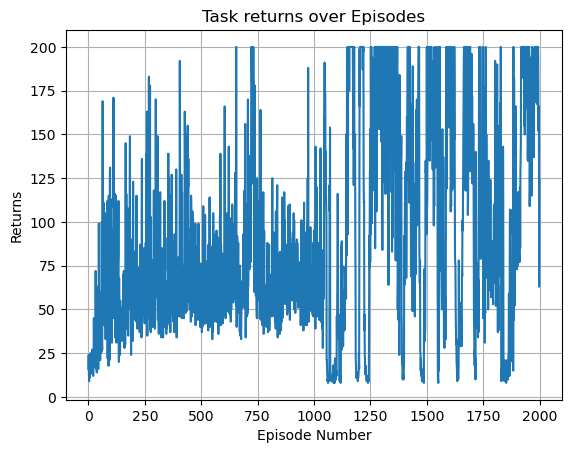

In [25]:
t.plot(save_name='cartpole_hd.png', cfg_path=Path().cwd()/'cfg'/'cartpole_rbf.yaml', cfg_args={}) # < 15 mins

The agent acting in the environment can be seen using the following command. Change the path to pick the episode you want to visualize. Bear in mind by default video saving for training is taken every 500 episodes

In [26]:
Video(Path().cwd()/'results'/'CartPole-v1'/'video'/'test'/'ex4_rbf-episode-0.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='T1'></a>
<div class=" alert alert-warning">
    <h4><b>Student Task 1.(b)</b> RBF approximation </h4> 

Now, let's test Q-learning with RBF approximation. In this task, we will do a feature transform using the Radial Basis Function. An input state will be transformed to as many features as samples $N$ are specified in the ```RBFSampler``` $\phi : \mathbb{R}^d \mapsto \mathbb{R}^N $. Then we will feed this $\mathbb{R}^N $ feature into a linear model to predict corresponding Q-values.

For this Task:
    
1. You need to modify functions ```featurize```, to **convert the state $s$ to a higher dimensional feature using** ```RBFSampler```.

2. Run the cell of ```class RBFAgent``` to update the class function

3. <span style="color:red"> **IMPORTANT: Directly come to this cell after the modifications, DO NOT RUN the handcraft feature cells again!!!** </span>

4. Run the cells below to check the performances of Q-learning with RBF approximation.
    
After the modifying, test the implementation on the Cartpole environment by running the ```train(agent)``` script with default configs. You can test the trained model with the ```test(agent, cfg_args=dict(save_video=true))``` script. 
</div>

In [32]:
# After modifying the function 'featurize', 
# 1. run the cell of class RBFAgent(object) to update the class
# 2. After update the class, directly run this cell (Skip the cells above of training hadncraft feature) 
# 2. now let's rerun the agent

with open(Path().cwd()/'cfg'/'cartpole_rbf.yaml', 'r') as f:
    cfg = t.Struct(**yaml.safe_load(f))        
agent = RBFAgent(n_actions=cfg.n_actions, gamma=cfg.gamma, batch_size=cfg.batch_size)

In [33]:
t.train(agent, cfg_path=Path().cwd()/'cfg'/'cartpole_rbf.yaml', cfg_args={}) # < 5 mins

Numpy/Torch/Random Seed:  436
{'ep_reward': 17.0, 'episode': 0, 'epsilon': 1.0, 'ep_avr': 0.0037796832621097565, 'ts_avr': 0.00019765645265579224}
{'ep_reward': 135.0, 'episode': 100, 'epsilon': 0.3333333333333333, 'ep_avr': 0.332517514526844, 'ts_avr': 0.004486493558146111}
{'ep_reward': 125.0, 'episode': 200, 'epsilon': 0.2, 'ep_avr': 0.5156524340063333, 'ts_avr': 0.004833640069803385}
{'ep_reward': 200.0, 'episode': 300, 'epsilon': 0.14285714285714285, 'ep_avr': 0.8329660508409142, 'ts_avr': 0.00556101223662222}
{'ep_reward': 200.0, 'episode': 400, 'epsilon': 0.1111111111111111, 'ep_avr': 1.0290039084479212, 'ts_avr': 0.005897548862700273}
{'ep_reward': 200.0, 'episode': 500, 'epsilon': 0.09090909090909091, 'ep_avr': 1.1813599334657192, 'ts_avr': 0.005951100588633191}
{'ep_reward': 200.0, 'episode': 600, 'epsilon': 0.07692307692307693, 'ep_avr': 1.2028787231445313, 'ts_avr': 0.006065624703813286}
{'ep_reward': 42.0, 'episode': 700, 'epsilon': 0.06666666666666667, 'ep_avr': 1.0626996

In [34]:
t.test(agent, cfg_path=Path().cwd()/'cfg'/'cartpole_rbf.yaml', cfg_args=dict(save_video=True)) 

Numpy/Torch/Random Seed:  436
{'episode': 0, 'ep_reward': 195.0}
{'episode': 1, 'ep_reward': 200.0}
{'episode': 2, 'ep_reward': 200.0}
{'episode': 3, 'ep_reward': 200.0}
{'episode': 4, 'ep_reward': 185.0}
{'episode': 5, 'ep_reward': 174.0}
{'episode': 6, 'ep_reward': 180.0}
{'episode': 7, 'ep_reward': 200.0}
{'episode': 8, 'ep_reward': 177.0}
{'episode': 9, 'ep_reward': 200.0}


Numpy/Torch/Random Seed:  436


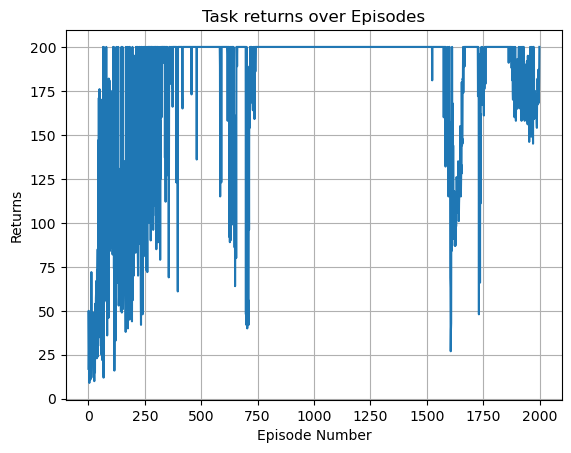

In [35]:
t.plot(save_name='cartpole_rbf.png', cfg_path=Path().cwd()/'cfg'/'cartpole_rbf.yaml', cfg_args={}) # < 5 mins

The agent acting in the environment can be seen using the following command. Change the path to pick the episode you want to visualize. Bear in mind by default video saving for training is taken every 500 episodes

In [45]:
Video(Path().cwd()/'results'/'CartPole-v1'/'video'/'test'/'ex4_rbf-episode-9.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> Considering Linear Features (10 points) </h3> 

Would it be possible to learn accurately Q-values for the Cartpole problem using linear features (by passing the state directly to a linear regressor)? Why/why not?
    
**Hint: directly return 'state' in function 'featurize'**
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


A linear regressor, when employed to learn Q-values solely from the state, is bound to encounter limitations in scenarios like this one. This is primarily due to its inherent incapacity to capture complex interactions between different features, which are often pivotal in environments like CartPole. For instance, the significance of a high angular velocity can vary greatly depending on the current angular position. To effectively handle such nuanced interactions, linear function approximation methods require the inclusion of additional features that account for the conjunction of feature values. Moreover, in our first experiment, we noted that utilizing both 'state' and 'abs(state)' as features resulted in the linear regressor model's inability to effectively converge and learn. Now, when we restrict our feature selection to only 'state', we further reduce the available feature space, posing an additional obstacle for the model to learn and achieve convergence effectively.

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> Experience Replay Buffer (10 points) </h3> 

In Task 1, we collect observed states, actions, and rewards into an experience replay buffer. During training we randomly sample mini-batches from this buffer. 
    
1.Why do we use the experience replay buffer, how does it affect the learning performance? 
    
2.Why do we sample the mini-batches randomly?

**Hint:** In machine learning, when training a model, we usually assume dataset includes i.i.d(independent and identically distributed) samples from a unknown distribution.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


1 - Incorporating an experience replay buffer into reinforcement learning confers several pivotal advantages that profoundly impact learning performance. Firstly, by randomly sampling mini-batches from the replay buffer, the algorithm effectively recycles past experiences multiple times, mitigating temporal correlations and enabling the agent to glean insights from a broader spectrum of experiences, thus enhancing sample efficiency. Secondly, in many environments, rare events, such as high-reward scenarios or critical state-action pairs, hold paramount importance in shaping optimal policies. The absence of an experience replay buffer could lead to the oversight or underrepresentation of these pivotal events in the learning process, whereas the replay buffer ensures their preservation and integration into learning. Thirdly, the random sampling mechanism from the replay buffer fosters exploration by encouraging the agent to revisit and learn from previous experiences, striking a refined balance between exploration and exploitation. Ultimately, these benefits coalesce to facilitate the agent's convergence to better policies.

2 - The practice of randomly sampling mini-batches from the experience replay buffer holds substantial significance for several compelling reasons. First and foremost, it endows the learning process with Independence and Identically Distributed (i.i.d.) properties, affording the application of statistical techniques and optimization algorithms with the assurance of convergence and generalization. Furthermore, this random sampling strategy effectively severs the temporal correlations that tend to arise in consecutive experiences, making it invaluable for breaking such dependencies. Moreover, it ensures that the agent explores a diverse range of state-action pairs rather than fixating on specific sequences of experiences, promoting a more comprehensive understanding of the environment. Lastly, random sampling safeguards against bias, fostering a more equitable learning process free from systemic distortions.

<a id='Q3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.3</b> Grid-based vs Function Approximators (10 points) </h3> 

In Exercise 3, we used grid-based Q-learning to balance the Cartpole. Are grid-based methods sample-efficient compared to the RBF function approximation methods? Why/why not?

**Hint:** An algorithm is said to be sample-efficient when it requires less samples (data) to reach
an optimal performance
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


Comparing grid-based methods to function approximation methods, it becomes evident that the former are less sample-efficient. Grid-based methods require a considerable number of episodes to learn behavior that often proves to be less efficient than that achieved through function approximation. As illustrated in the previous exercise's plot, the agent took more episodes to learn and converge, whereas in this exercise's "rbf" section, we observed faster learning and convergence. Additionally, it's important to note that Grid-Based Q-Learning applied to a continuous state space tends to be inefficient. This inefficiency arises because function approximation allows parameter updates based on observed states to influence unseen states, making it considerably more sample-efficient, particularly when the function can effectively approximate the optimal Q-function. In summary, RBF function approximation methods are generally regarded as more sample-efficient, particularly in high-dimensional state spaces where grid-based methods can suffer from the curse of dimensionality in continuous environments.

<a id='T2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 2.</b> Visualizing the Policy (10 points) </h3> 

Create a 2D plot of policy (best action in terms of state) learned with RBF in terms of $x$ and θ for $\dot{x} = 0$ and $\dot{\theta} = 0$, such that θ is on the horizontal axis and $x$ is on the vertical axis. The plot will be visualized below.

**Hint 1 :** You can fix $\dot{x} = 0$ and $\dot{\theta} = 0$ and discretize the state-space for $x$ and $\theta$.

**Hint 2 :** You can directly use the code in ***excercise 1 Task 4*** to visualize the policy.
    
**Hint 3 :** For CartPole environment state specifications, find them here https://gymnasium.farama.org/environments/classic_control/cart_pole/
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


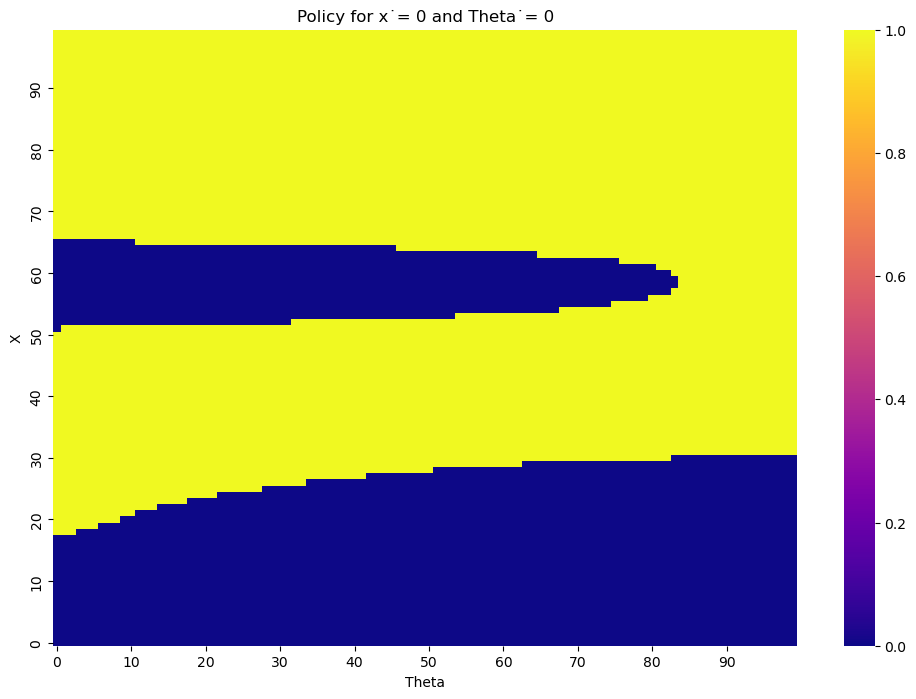

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# define and reload the RBF agent, which is trained with RBF feature!!!!
with open(Path().cwd()/'cfg'/'cartpole_rbf.yaml', 'r') as f:
    cfg = t.Struct(**yaml.safe_load(f))        
agent = RBFAgent(n_actions=cfg.n_actions, gamma=cfg.gamma, batch_size=cfg.batch_size)
agent.load(Path().cwd()/'results/CartPole-v1/model/')

########## Your code starts here ##########
n_samples = 100
x_val = np.linspace(-2.4, 2.4, n_samples) 
theta_val = np.linspace(-0.2095, 0.2095, n_samples) 

grid = []
for x in x_val:
    for theta in theta_val:
        grid.append((x, theta))
        
best_actions = np.zeros((len(x_val), len(theta_val)))

for i, (x, theta) in enumerate(grid):
    best_action = agent.get_action(np.array([x, 0, theta, 0]))
    best_actions[i // len(theta_val), i % len(theta_val)] = best_action

plt.figure(figsize=(12, 8))
sns.heatmap(best_actions, cmap='plasma', xticklabels=10, yticklabels=10, cbar=True)
plt.xlabel('Theta')
plt.ylabel('X')
plt.title('Policy for x˙= 0 and Theta˙= 0')
plt.gca().invert_yaxis()
plt.show()
########## Your code ends here #############



# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex4_dpn.ipynb``` and ```ex4_rbf.ipynb```) are answered and the necessary plots are saved in the appropriate locations. The relevant plots and files need to be included for this part of assignment are:


- Training performance plots:
  - `cartpole_hd.png`: Training performance of handcrafted feature plots in terms of episode and episodic reward
  - `cartpole_rbf.png`: training performance of rbf feature plots in terms of episode and episodic reward 
<br>
<br>

  

- Model files:
  - `rbf.kpl`: Trained model


Ensure the correct model files and plots are saved in paths:
- ```results/CartPole-v1/cartpole_rbf.png``` Training result for Cartpole environment
- ```results/CartPole-v1/cartpole_hd.png```  Training result for Cartpole environment
- ```results/CartPole-v1/model/rbf.kpl``` Model for Cartpole environment


<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex4_dqn.ipynb```** </span>

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer to the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)

In [ ]:
hrs = None

2) Difficulty of each task/question from 1-5 (int or float)

In [ ]:
T1_a = None   # Implementing Hand feature 
T2_b = None   # Implementing RBF feature 
Q1_1 = None # Question 1.1 Considering linear features (10 points)
Q1_2 = None # Question 1.2 Experience replay (10 points)
Q1_3 = None # Question 1.3 Grid vs Function (10 points)
Q2 = None # Question 2 Policy visualization (10 points)

3) How well did you understand the content of the task/question from 1-5? (int or float)

In [ ]:
T1_a = None   # Implementing Hand feature 
T2_b = None   # Implementing RBF feature 
Q1_1 = None # Question 1.1 Considering linear features (10 points)
Q1_2 = None # Question 1.2 Experience replay (10 points)
Q1_3 = None # Question 1.3 Grid vs Function (10 points)
Q2 = None # Question 2 Policy visualization (10 points)

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
Please share any additional feedback, suggestions, or comments you have about the lecture, assignment, or course content. Your input is valuable in helping us improve the learning experience.

DOUBLE CLICK HERE TO EDIT, CLEAR THIS TEXT AND ANSWER HERE